<a href="https://colab.research.google.com/github/amirulhaq/Keras-Implementation-with-Inception/blob/master/Keras_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras Implementation with Inception

This is the third homework of Intelligence Video Surveillance Course.
In this code we will perform and image recognition using Keras and GoogleNet (Inception v3)
Reference used in this project are taken from:

https://keras.io/preprocessing/image/

https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

## A Bit About Inception v3

![alt text](https://drive.google.com/uc?id=1IlH7QNm9g0DHqJU1wxwUAlqHC0UbUOxj)

In the image above we can see the Inception v3 network architecture. Inception is famous for being one of the most complex deep learning network at its time. While most deep learning network have a simple one stream network structure, Inception's structure branched in many paths. It have its merit though, compared to other network at that time like VGG, Inception have significantly less parameters and therefore reduced computational needs.

In [0]:
#Check your environment! (Optional)
!pip list

In [0]:
#Import all of the needed library
import keras
import numpy as np
from keras import applications
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from google.colab import drive
import os

#Initiate Google Drive to fetch and save your files and datasets
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/')

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
87916544/87910968 [==============================] - 3s 0us/step


# Add Your Own Dataset to Model

In here we will make our own dataset with Dog, Penguin, and Racoon Pictures. We will make our dataset in google drive folder with directory as shown in picture below.

![alt text](https://cdn-images-1.medium.com/max/800/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg) 

Picture taken from Medium user Vijayabhaskar J


In [0]:
#Generate train, validation, and test data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './ivls_dataset/train',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=10,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    directory=r'./ivls_dataset/validation',
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=5,
    class_mode='categorical',
    shuffle=True,
    seed=42)

Found 215 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Found 40 images belonging to 3 classes.


#Train the New Model with Your Own Dataset

TO decide which layer we should train we can see this illustration below provided in this article https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

Because we only have small datasets(300 images, 100 for each classes). We will consider our case to be in the Quadrant 3. It means that we are going to train only the top layers and leave the bottom layer which contain fully connected layers frozen. Freezing the bottom layers means that we don't need to train the fully connected layers which requires the most computational resources.

![alt text](https://drive.google.com/uc?id=15IJbjktlx7G90EcAShvk31rRN4GzpT4R)

---


![alt text](https://drive.google.com/uc?id=18ekTORifa4aDb6_DmvTTc18INnRgff01)


In [0]:
# Train the model on the new data for a few epochs
# Change to own datasets
# Create checkpoint
from keras.callbacks import ModelCheckpoint
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

filepath1="weightsbestonly1.hdf5"
filepath2="weightsbestonly2.hdf5"
checkpoint1 = ModelCheckpoint(filepath1, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list1 = [checkpoint1]
callbacks_list2 = [checkpoint2]

model.fit_generator(
        train_generator,
        steps_per_epoch=20,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,
        epochs=500, callbacks=callbacks_list1)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

Epoch 1/500
20/20 [==============================] - 66s 3s/step - loss: 3.2122 - val_loss: 2.3004
Epoch 2/500


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


20/20 [==============================] - 5s 246ms/step - loss: 1.5402 - val_loss: 1.3862
Epoch 3/500
20/20 [==============================] - 3s 151ms/step - loss: 1.0229 - val_loss: 0.3839
Epoch 4/500
20/20 [==============================] - 3s 141ms/step - loss: 0.7414 - val_loss: 2.3134
Epoch 5/500
20/20 [==============================] - 3s 155ms/step - loss: 0.7731 - val_loss: 6.1451
Epoch 6/500
20/20 [==============================] - 3s 148ms/step - loss: 0.6989 - val_loss: 1.6670
Epoch 7/500
20/20 [==============================] - 3s 160ms/step - loss: 0.8457 - val_loss: 2.0641
Epoch 8/500
20/20 [==============================] - 3s 150ms/step - loss: 0.6276 - val_loss: 2.0470
Epoch 9/500
20/20 [==============================] - 3s 148ms/step - loss: 0.6650 - val_loss: 1.6500
Epoch 10/500
20/20 [==============================] - 3s 152ms/step - loss: 0.8430 - val_loss: 2.2201
Epoch 11/500
20/20 [==============================] - 3s 152ms/step - loss: 0.5514 - val_loss: 2.6354


In [0]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD, adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(
        train_generator,
        steps_per_epoch=20,
        epochs=500,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID, callbacks=callbacks_list2)

# Evaluate Model
# model.evaluate_generator(generator=valid_generator)

Epoch 1/500
20/20 [==============================] - 9s 461ms/step - loss: 2.5879 - acc: 0.7800 - val_loss: 8.9545 - val_acc: 0.4444

Epoch 00001: val_acc improved from -inf to 0.44444, saving model to weightsbestonly2.hdf5
Epoch 2/500
20/20 [==============================] - 2s 120ms/step - loss: 4.2856 - acc: 0.6799 - val_loss: 5.4465 - val_acc: 0.6222

Epoch 00002: val_acc improved from 0.44444 to 0.62222, saving model to weightsbestonly2.hdf5
Epoch 3/500
20/20 [==============================] - 3s 150ms/step - loss: 2.7283 - acc: 0.7850 - val_loss: 7.3866 - val_acc: 0.5111

Epoch 00003: val_acc did not improve from 0.62222
Epoch 4/500
20/20 [==============================] - 3s 163ms/step - loss: 2.4237 - acc: 0.7652 - val_loss: 7.1287 - val_acc: 0.5556

Epoch 00004: val_acc did not improve from 0.62222
Epoch 5/500
20/20 [==============================] - 4s 184ms/step - loss: 1.5622 - acc: 0.8403 - val_loss: 6.2553 - val_acc: 0.5778

Epoch 00005: val_acc did not improve from 0.622

# Get Accuracy Data

Plot the training information on accuracy and loss for each epoch

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


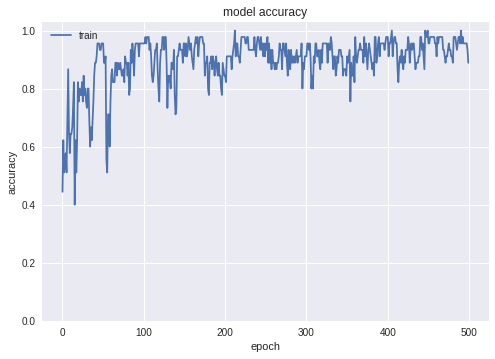

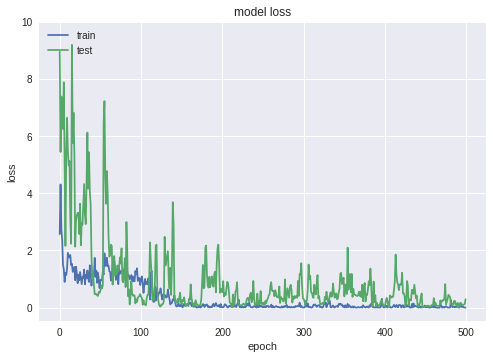

In [0]:
import matplotlib.pyplot as plt

# Plot training error
print(history.history.keys())
plt.plot(history.history['val_acc'])
plt.ylim(ymin=0)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(ymax=10)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test the Model with New Data

After we perform the training and validation, next we want to use our model to predict a test data on new category that we made (Dog, Penguin, and Racoon)

In [0]:
import pandas as pd
test_generator = test_datagen.flow_from_directory(
        'ivls_dataset/test/',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=1,
        class_mode=None)

test_generator.reset()
pred = model.predict_generator(test_generator,verbose=1, steps = 40)
predicted_class_indices = np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames = test_generator.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 40 images belonging to 1 classes.
40/40 [==============================] - 2s 39ms/step


# Results and Coclusion

![alt text](https://drive.google.com/uc?id=1hAV5SnfHexQdAOEZ6860eYC4s6BZgjFD)

The prediction and ground truth results show an abysmal performance from our model. We only get 17 out of 40 predictions correct, which is only 42.5 percent accuracy.

Although the training and validation shows a good results, the test results show that our model may suffer from overfitting because of the small datasets. The next step of our project is to add more datasets and probably change the network configuration because we suspect that we made a wrong decission about which layers that needs to be trained.